# AdaBoost

Analyzing the gear shaft process. Objectives is to classify on the basis of the measured values whether the part was produced correctly. The measurement was exported to a csv file to train a classifier. 

![](GearShaftProcess.JPG)


Adaboost was chosen as classifier with a DecisionTreeClassifier as weak classifier. the results are very good but difficult to interpret.

In [1]:
import sklearn.tree
import sklearn.metrics
import numpy as np
% matplotlib inline
import matplotlib.pyplot as plt
import csv

In [2]:
class AdaBooster:
    
    def __init__(self, weak_learner, iterations):
        '''
        weak_learner: sklearn classifier - G_m
        iterations: number of iteration to train - M
        '''
        self.weak_learner = weak_learner
        self.iterations = iterations
        
        # 1. Initialize some more lists
        self.classifiers = list() # trained classifiers G_m
        self.alphas = list()      # classifier weights       
    
    def fit(self, X, y):
        # initialize the observation weights
        w = np.ones_like(y) / X.shape[0]
        
        for it in range(self.iterations):
            # Fit a weak classifier
            tmp_learner = sklearn.base.clone(self.weak_learner)
            tmp_learner.fit(X, y, sample_weight=w)
            self.classifiers.append(tmp_learner)
            
            # Compute error
            y_pred = tmp_learner.predict(X)
            error = np.sum(w * (y != y_pred))
            error /= np.sum(w)
            
            # Compute classifier weight
            alpha = np.log((1 - error) / error)
            self.alphas.append(alpha)
            
            # Update observation weights
            w *= np.exp(alpha * (y != y_pred))
            
    def predict(self, X):
        # Compute predictions by looping over all classifiers 
        # and adding weighted predictions. 
        # The actual output should be 
        # -1 if y_i <= 0 and 1 otherwise
    
        pred = np.zeros(X.shape[0])
        for alpha, c in zip(self.alphas, self.classifiers):
            tmp_pred = c.predict(X)
            pred += alpha * tmp_pred
        pred[pred > 0] = 1
        pred[pred <= 0] = -1
        return pred
    
    def staged_predict(self, X):
        # returns predictions for X for all iterations 
        # this is for convenience to simplify computing
        # train/test error for all iterations

        staged_predictions = []
        pred = np.zeros(X.shape[0])
        for alpha, c in zip(self.alphas, self.classifiers):
            tmp_pred = c.predict(X)
            pred += alpha * tmp_pred
            
            staged_prediction = pred.copy()
            staged_prediction[staged_prediction > 0] = 1
            staged_prediction[staged_prediction <= 0] = -1            
            staged_predictions.append(staged_prediction)
            
        return staged_predictions

During the test with the system it happened that the sensor was busy. the empty cells were inserted in the csv. these cells have to be replaced with the average of the feature.

In [3]:
def fill_missing_values(X):
    for r in range(X.shape[0]):
        sum = 0.
        n = 0
        for c in range(X.shape[1]):
            try:
                sum += float(X[r, c])
                n += 1
            except:
                pass

        mean = sum / n

        for c in range(X.shape[1]):
            if (X[r, c] == ''):
                X[r, c] = str(mean)
                
    return X          


To analyze the quality of the algorithm the accurcy for all iteration is displayed

In [4]:
def plot_train_test_error(model, X_train, y_train, X_test, y_test):
    ''' Shows a plot with train/test error over iterations

    model (AdaBooster): trained AdaBoost algorithm
    X_train (array): [#samples, #features]
    y_train (array): [#samples, ]
    X_test (array): [#samples, #features]
    y_test (array): [#samples, ]
    '''
    # Loop over all predictions and compute accuracy
    y_pred_train = model.staged_predict(X_train)
    training_errors = [sklearn.metrics.accuracy_score(y_train, y_pred) for y_pred in y_pred_train]
    
    y_pred_test = model.staged_predict(X_test)
    test_errors = [sklearn.metrics.accuracy_score(y_test, y_pred) for y_pred in y_pred_test]
    
    # Plot results
    x_values = np.arange(1, len(training_errors) + 1)

    plt.plot(x_values, training_errors, label="training")
    plt.plot(x_values, test_errors, label="test")
    plt.xlabel("iterations")
    plt.ylabel("accuracy")
    plt.legend(loc="best")
    plt.ylim([0, 1])
    
    plt.show()

* In csv the data is present as a string. These must first be converted to floating point values. The classes are 'OK' and 'Failure'. These must converted to -1 and 1.

* The data are then divided into trainings and validation data (70%/30%)

* The adaboost is trained with the data. The result graph is then created

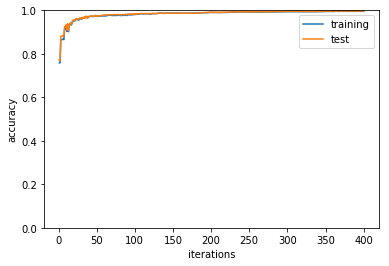

In [5]:
with open('./Dataset.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=';')
    
    data = np.asmatrix(list(reader))[1:]
    n = data.shape[0]
    
    np.random.shuffle(data)
    
    X = data[:,:data.shape[1]-2]
    y = data[:, data.shape[1]-1]
   
    X = fill_missing_values(X).astype(float)
    y = np.where(y == 'OK', 1, -1).reshape(-1)
    
    n_train = int(n * .7)
    
    X_train = X[:n_train]
    y_train = y[:n_train]
    X_test = X[n_train:]
    y_test = y[n_train:]

    weak_learner = sklearn.tree.DecisionTreeClassifier(max_depth=1)
    adaboost = AdaBooster(weak_learner=weak_learner, iterations=400)

    adaboost.fit(X=X_train, y=y_train)
    
    plot_train_test_error(model=adaboost, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)